In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer
import seaborn as sns
from imblearn.over_sampling import SMOTE

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping
# Set random seed for reproducibility
tf.random.set_seed(42)
np.random.seed(42)

In [ ]:
def load_and_split_dataset(filename, n_splits=5, random_state=42):
  df = pd.read_csv(filename)
  df_train, df_test = train_test_split(df, test_size=0.2, random_state=42)

  return df_train, df_test

In [ ]:
def dataset_preprocessing(df):
  df.drop('id', axis='columns', inplace=True)

  # Impute missing values in 'bmi' column using SimpleImputer
  imputer = SimpleImputer(strategy='mean')
  df['bmi'] = imputer.fit_transform(df[['bmi']])

  df['bmi_cat'] = pd.cut(df['bmi'], bins = [0, 19, 25,30,10000], labels = ['Underweight', 'Ideal', 'Overweight', 'Obesity'])
  df['age_cat'] = pd.cut(df['age'], bins = [0,13,18, 45,60,200], labels = ['Children', 'Teens', 'Adults','Mid Adults','Elderly'])
  df['glucose_cat'] = pd.cut(df['avg_glucose_level'], bins = [0,90,160,230,500], labels = ['Low', 'Normal', 'High', 'Very High'])

  df.drop('bmi', axis='columns', inplace=True)
  df.drop('age', axis='columns', inplace=True)
  df.drop('avg_glucose_level', axis='columns', inplace=True)

  df.drop('ever_married', axis='columns', inplace=True)
  df.drop('Residence_type', axis='columns', inplace=True)
  df.drop('work_type', axis='columns', inplace=True)

  # print(df.head().T)

  # Identify categorical features
  categorical_features = [col for col in df.columns if col not in df.describe().columns]

  # Identify binary categorical features
  binary_categorical_features = [col for col in categorical_features if df[col].nunique() == 2]

  # Identify non-binary categorical features
  non_binary_categorical_features = [col for col in categorical_features if col not in binary_categorical_features]

  # Apply label encoding for binary categorical features
  label_encoder = LabelEncoder()

  for feature in binary_categorical_features :
    df[feature] = label_encoder.fit_transform(df[feature])

  # Apply one-hot encoding using get_dummies for non-binary categorical features
  df = pd.get_dummies(df, columns=non_binary_categorical_features)

  df.drop('gender_Other', axis='columns', inplace=True)

  df_y = df['stroke']
  df.drop(['stroke'], inplace=True, axis=1)

  return df, df_y

In [ ]:
def data_sampling(df, df_y, oversample_ratio=0.2):
    print("Inside sampling func")
    # SMOTE
    smote = SMOTE(random_state=42, sampling_strategy=oversample_ratio)
    sampled_X, sampled_Y = smote.fit_resample(df, df_y)
    print("After SMOTE:", sampled_X.shape, sampled_Y.shape)

    df = pd.concat([sampled_X, sampled_Y], axis=1)
    class_1_rows = df[df['stroke'] == 1]
    class_0_rows = df[df['stroke'] == 0].sample(n=class_1_rows.shape[0], random_state=42)
    # Concatenate the selected rows
    df = pd.concat([class_1_rows, class_0_rows])
    df = df.sample(frac=1).reset_index(drop=True)

    # separate target column
    df_y = df['stroke']
    df.drop(['stroke'], inplace=True, axis=1)

    return df, df_y

In [ ]:
train_data, test_data = load_and_split_dataset('./dataset.csv')
preprocessed_train_X, preprocessed_train_Y = dataset_preprocessing(train_data)
preprocessed_test_X, preprocessed_test_Y = dataset_preprocessing(test_data)

In [ ]:
sampled_train_X, sampled_train_Y = data_sampling(preprocessed_train_X, preprocessed_train_Y)

Inside sampling func
After SMOTE: (40917, 20) (40917,)


In [ ]:
print(preprocessed_train_X.shape)
print(sampled_train_X.shape)
print(preprocessed_train_Y.shape)
print(sampled_train_Y.shape)
print(preprocessed_train_Y.value_counts())
print(sampled_train_Y.value_counts())

(34720, 20)
(13638, 20)
(34720,)
(13638,)
0    34098
1      622
Name: stroke, dtype: int64
0    6819
1    6819
Name: stroke, dtype: int64


In [ ]:
X_train = sampled_train_X.to_numpy()
Y_train = sampled_train_Y.to_numpy()
X_test = preprocessed_test_X.to_numpy()
Y_test = preprocessed_test_Y.to_numpy()

In [ ]:
callback = EarlyStopping(monitor='val_loss', patience=3)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-2,
    decay_steps=10000,
    decay_rate=0.9)

k_folds=5

stratified_kfold = StratifiedKFold(n_splits=k_folds, shuffle=True, random_state=42)

for fold, (train_indices, val_indices) in enumerate(stratified_kfold.split(X_train, Y_train)):
    print(f"Fold {fold+1}/{k_folds}")
    X_train_fold = X_train[train_indices]
    Y_train_fold = Y_train[train_indices]
    X_val_fold = X_train[val_indices]
    Y_val_fold = Y_train[val_indices]

    # Define and compile the model
    model = Sequential([
        Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.05), input_shape=(X_train.shape[1],)),
        Dropout(0.3),
        Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.05)),
        Dropout(0.2),
        Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.05)),
        Dropout(0.1),
        Dense(1, activation='sigmoid')
    ])
    model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=lr_schedule), loss='binary_crossentropy', metrics=['accuracy'])
    # Fit the model
    history = model.fit(X_train_fold, Y_train_fold, batch_size=32, epochs=50, validation_data=(X_val_fold, Y_val_fold), callbacks=[callback])

Fold 1/5
Epoch 1/50
341/341 [==============================] - 3s 6ms/step - loss: 20.7179 - accuracy: 0.7017 - val_loss: 14.6399 - val_accuracy: 0.7727
Epoch 2/50
341/341 [==============================] - 2s 5ms/step - loss: 10.8218 - accuracy: 0.7632 - val_loss: 7.7528 - val_accuracy: 0.7676
Epoch 3/50
341/341 [==============================] - 2s 5ms/step - loss: 5.8242 - accuracy: 0.7677 - val_loss: 4.2714 - val_accuracy: 0.7643
Epoch 4/50
341/341 [==============================] - 2s 6ms/step - loss: 3.2914 - accuracy: 0.7667 - val_loss: 2.5017 - val_accuracy: 0.7636
Epoch 5/50
341/341 [==============================] - 2s 7ms/step - loss: 1.9993 - accuracy: 0.7671 - val_loss: 1.5965 - val_accuracy: 0.7650
Epoch 6/50
341/341 [==============================] - 3s 8ms/step - loss: 1.3377 - accuracy: 0.7689 - val_loss: 1.1315 - val_accuracy: 0.7639
Epoch 7/50
341/341 [==============================] - 2s 6ms/step - loss: 0.9964 - accuracy: 0.7669 - val_loss: 0.8925 - val_accuracy: 0

In [ ]:
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Assuming you have already trained your model and have X_test and y_test
y_pred_proba = model.predict(X_test)  # Predict probabilities

# Convert probabilities to binary predictions
y_pred_binary = (y_pred_proba >= 0.5).astype(int)

# Calculate evaluation metrics
accuracy = accuracy_score(Y_test, y_pred_binary)

# Calculate precision and recall for both classes
precision_0 = precision_score(Y_test, y_pred_binary, pos_label=0)
recall_0 = recall_score(Y_test, y_pred_binary, pos_label=0)

precision_1 = precision_score(Y_test, y_pred_binary, pos_label=1)
recall_1 = recall_score(Y_test, y_pred_binary, pos_label=1)

# Calculate F1 score for class 1 (stroke)
f1_1 = f1_score(Y_test, y_pred_binary, pos_label=1)

# Calculate F1 score for class 0 (non-stroke)
f1_0 = f1_score(Y_test, y_pred_binary, pos_label=0)

roc_auc = roc_auc_score(Y_test, y_pred_proba)

print("Accuracy:", accuracy)
print("Precision (Non-Stroke):", precision_0)
print("Precision (Stroke):", precision_1)

print("Recall (Non-Stroke):", recall_0)
print("Recall (Stroke):", recall_1)

print("F1 Score (Non-Stroke):", f1_0)
print("F1 Score (Stroke):", f1_1)
print("ROC AUC Score:", roc_auc)

272/272 [==============================] - 1s 3ms/step
Accuracy: 0.7411290322580645
Precision (Non-Stroke): 0.9940138626339005
Precision (Stroke): 0.05274442538593482
Recall (Non-Stroke): 0.7406972649371992
Recall (Stroke): 0.7639751552795031
F1 Score (Non-Stroke): 0.8488598910338333
F1 Score (Stroke): 0.098676293622142
ROC AUC Score: 0.8127309871467433


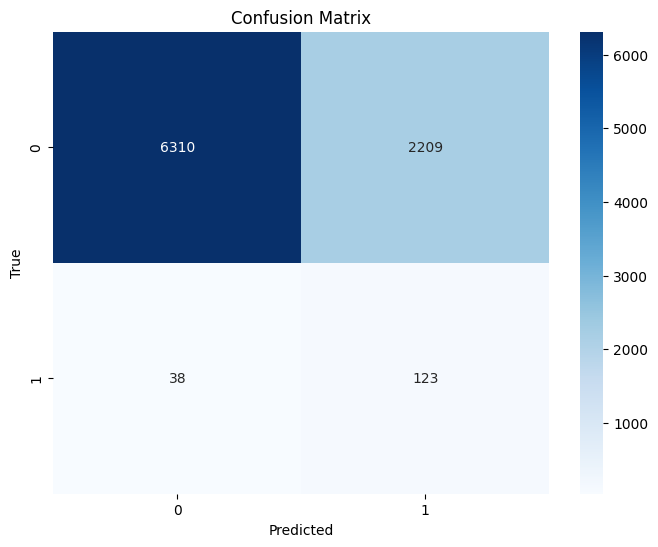

In [ ]:
from sklearn.metrics import confusion_matrix
# Compute confusion matrix
cm = confusion_matrix(Y_test, y_pred_binary)

# Plot confusion matrix as a heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(Y_test),
            yticklabels=np.unique(Y_test))
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

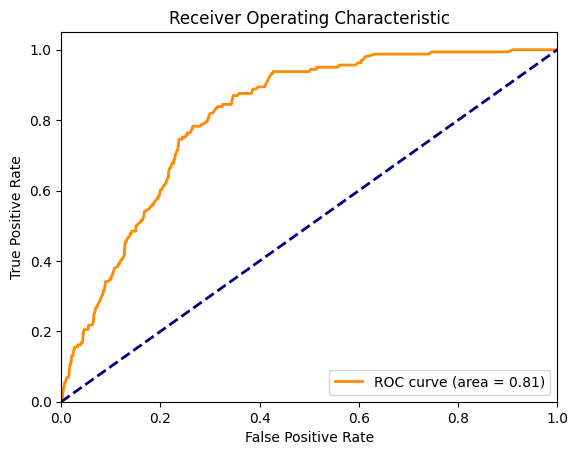

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

# Assuming you have predictions from your FNN stored in y_score
# and the true labels stored in y_true

# Compute ROC curve
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_proba)

# Compute area under the curve (AUC)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.show()